# Задание

        1) Преобразование данных (3 балла)
                * объяснить значение признаков, что будут использованы
                * выполнить корреляционный анализ признаков, попытаться установить зависимые
                * произвести выбор признаков
                * провести предобработку данных (data preprocessing — закодируйте как-нибудь признаки, попробуйте как минимум два различных способа кодирования)
        2) Опробовать как минимум три разные модели (2 балла)
        3) Использовать ensemble модель с обучаемыми и не обучаемыми весами (2 балла)
        4) Сделать объяснимую модель (2 балла)
        5) Обработать результаты, провести error analysis, сравнить модели (1 балл)

## Настройки/Гиперпараметры/Импорты

In [1]:
import pandas as pd # для удобной работы с датасетом
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения графиков (heatmap)
import torch # для создания модели
from sklearn.model_selection import train_test_split # для разбиения на train - test выборки
from torch import nn, optim # для слоёв модели и оптимайзера

from sklearn.neighbors import KNeighborsClassifier # KNN классификатор
from sklearn.ensemble import RandomForestClassifier # ансамблевая модель
from sklearn.model_selection import GridSearchCV # для отбора оптимальных параметров

from sklearn.metrics import f1_score # для подсчёта метрики f1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # для матрицы TP, FP, TN, FN
from sklearn.preprocessing import MinMaxScaler # для приведения признаков к одной области значений (0+)

c:\Users\User\anaconda3\envs\gpu\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
test_size = 0.25 # размер датасета для тестирования
random_state = 15 # случайное значение для генераций
learning_rate = 0.01 # шаг(скорость) обучения
num_epochs = 500 # число эпох

n_estimators = 10 # количество моделей в ансамбле (кастомном)

# Описание датасета

Глиомы являются наиболее распространенными первичными опухолями головного мозга. Они могут быть классифицированы как LGG (глиома низкой степени злокачественности) или GBM (мультиформная глиобластома) в зависимости от гистологических критериев / критериев визуализации. Клинические и молекулярные факторы/мутации также очень важны для процесса оценки. Молекулярные тесты стоят дорого, чтобы помочь точно диагностировать пациентов с глиомой. В этом наборе данных рассмотрены наиболее часто мутирующие 20 генов и 3 клинических признака из проектов TCGA-LGG и TCGA-GBM по глиоме головного мозга. Задача прогнозирования состоит в том, чтобы определить, является ли пациент LGG или GBM с заданными клиническими и молекулярными признаками / мутациями. Основная цель состоит в том, чтобы найти оптимальное подмножество мутационных генов и клинических признаков для процесса классификации глиомы с целью повышения производительности и снижения затрат.

## 1) Преобразование данных

### Первичные преобразования

In [3]:
data_train = pd.read_csv("./data/train.csv", sep=',').set_index('Unnamed: 0') # считывание датасета (используем первый столбец без названия как индекс)
data_validation = pd.read_csv("./data/test.csv", sep=',').set_index('Unnamed: 0')
data_train

,Grade,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,GBM,TCGA-06-A6S0,Male,79 years 183 days,Glioblastoma,black or african american,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-HT-8106,Male,53 years 197 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
2,LGG,TCGA-HT-7607,Female,61 years 305 days,"Astrocytoma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-QH-A6X5,Female,58 years 55 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
4,LGG,TCGA-P5-A5F1,Male,30 years 113 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,GBM,TCGA-06-0744,Male,67 years,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
599,LGG,TCGA-DU-A6S7,Female,27 years 309 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
600,LGG,TCGA-DU-5853,Male,29 years 32 days,Mixed glioma,white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


* "Grade" — таргет, означающий тип опухоли головного мозга, LGG или GBM. (тип - категориальный, бинарный)
* "Case_ID" — уникальный идентификатор пациента. (тип - категориальный)
* "Gender" — первый клинический признак, пол пациента. (тип - категориальный, бинарный)
* "Age_at_diagnosis" — второй клинический признак, возраст пациента. (тип ~ числовой)
* "Primary_Diagnosis" — первичный поставленный диагноз. (тип - категориальный)
* "Race" — третий клинический признак, раса пациента. (тип - категориальный)
* Остальные столбцы — гены. (тип - категориальный, бинарный)

In [4]:
data_train.describe()

,Grade,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
count,603,603,603,603,603,603,603,603,603,603,...,603,603,603,603,603,603,603,603,603,603
unique,2,603,3,595,7,6,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,LGG,TCGA-06-A6S0,Male,53 years 233 days,Glioblastoma,white,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
freq,349,1,350,2,253,537,319,357,458,501,...,569,576,578,582,582,584,583,585,588,585


* Столбец "Case_ID" — просто уникальный идентификатор пациента, что не должен влиять на наличие у него LGG или GBM, поэтому его тоже можно удалить.
  
* Столбец "Primary_Diagnosis" — первичный поставленный диагноз, удаляем, так как предсказание должно основываться на генах и клинических признаках по условию задачи.

In [5]:
data_train = data_train.drop(columns=["Case_ID", "Primary_Diagnosis"]) # удаление столбцов
data_validation = data_validation.drop(columns=["Case_ID", "Primary_Diagnosis"]) # удаление столбцов

In [6]:
data_train = data_train.drop(data_train[data_train.duplicated()].index) # проверка на дублирующиеся данные в датасете
data_train.info() # вывод информации о данных

<class 'pandas.core.frame.DataFrame'>
Index: 603 entries, 0 to 602
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Grade             603 non-null    object
 1   Gender            603 non-null    object
 2   Age_at_diagnosis  603 non-null    object
 3   Race              603 non-null    object
 4   IDH1              603 non-null    object
 5   TP53              603 non-null    object
 6   ATRX              603 non-null    object
 7   PTEN              603 non-null    object
 8   EGFR              603 non-null    object
 9   CIC               603 non-null    object
 10  MUC16             603 non-null    object
 11  PIK3CA            603 non-null    object
 12  NF1               603 non-null    object
 13  PIK3R1            603 non-null    object
 14  FUBP1             603 non-null    object
 15  RB1               603 non-null    object
 16  NOTCH1            603 non-null    object
 17  BCOR              603

        В данных нет дубликатов.

In [7]:
# ищем строки с "плохими"/"мусорными" значениями и заменяем их самыми частыми значениями по датасету
for row in range(data_train.shape[0]): # идём по строкам
    for col in data_train.columns: # идём по столбцам
        if data_train.loc[row][col] in ["--", "not reported"]: # если в строке встретилось "мусорное" значение у признака
            data_train.loc[row][col] = data_train.describe()[col]["top"] # заменяем его на самое часто встречаемое

# аналогично для валидационного датасета
for row in range(data_validation.shape[0]): # идём по строкам
    for col in data_validation.columns: # идём по столбцам
        if data_validation.loc[row][col] in ["--", "not reported"]: # если в строке встретилось "мусорное" значение у признака
            data_validation.loc[row][col] = data_train.describe()[col]["top"] # заменяем его на самое часто встречаемое

In [8]:
# преобразуем числовой признак - возраст (строку) в число (Continuous признак)
for i in range(data_train.shape[0]): # идём по строкам
    row = data_train["Age_at_diagnosis"][i].split() # берём строку и разделяем её по пробелам
    data_train["Age_at_diagnosis"][i] = round(int(row[0]) + (int(row[2])/365 if len(row)==4 else 0), 4) # преобразовываем строку, беря из неё числа - года и дни/365 (останавливаемся на 4 знаках после запятой)
data_train["Age_at_diagnosis"] = data_train["Age_at_diagnosis"].astype(float) # кастим в float тип

# аналогично для валидационного датасета
for i in range(data_validation.shape[0]): # идём по строкам
    row = data_validation["Age_at_diagnosis"][i].split() # берём строку и разделяем её по пробелам
    data_validation["Age_at_diagnosis"][i] = round(int(row[0]) + (int(row[2])/365 if len(row)==4 else 0), 4) # преобразовываем строку, беря из неё числа - года и дни/365 (останавливаемся на 4 знаках после запятой)
data_validation["Age_at_diagnosis"] = data_train["Age_at_diagnosis"].astype(float) # кастим в float тип

In [9]:
# скалируем значение возраста, так как он сильно выбивается по значениям
age_scale = MinMaxScaler().fit(torch.tensor(data_train["Age_at_diagnosis"].values.reshape((-1,1)))) # готовим скейлер для данных о возрасте (reshape((-1,1)) - данные в виде одного столбца)

data_train["Age_at_diagnosis"] = age_scale.transform(torch.tensor(data_train["Age_at_diagnosis"].values.reshape((-1,1)))) # трансформируем данные
data_validation["Age_at_diagnosis"] = age_scale.transform(torch.tensor(data_validation["Age_at_diagnosis"].values.reshape((-1,1)))) # трансформируем данные

In [10]:
# преобразуем категориальные признаки (строки) в числа (LABEL ENCODING)
data_train['Grade'].replace(['LGG', 'GBM'], [0, 1], inplace=True)
data_train['Gender'].replace(['Male', 'Female'], [0, 1], inplace=True)
data_train['Race'].replace(['white', 'asian', 'black or african american', 'american indian or alaska native'], [0, 1, 2, 3], inplace=True)
for col in data_train.columns[4:]:
    data_train[col].replace(['NOT_MUTATED', 'MUTATED'], [0, 1], inplace=True)

# аналогично для валидационного датасета
data_validation['Gender'].replace(['Male', 'Female'], [0, 1], inplace=True)
data_validation['Race'].replace(['white', 'asian', 'black or african american', 'american indian or alaska native'], [0, 1, 2, 3], inplace=True)
for col in data_validation.columns[3:]: # с третьего столбца, так как столбец "Grade" отсутствует
    data_validation[col].replace(['NOT_MUTATED', 'MUTATED'], [0, 1], inplace=True)

In [11]:
data_train # вывод датасета после первичных преобразований

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.869282,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0.522506,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0.633316,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0.584096,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0.212216,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,1,0,0.702298,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599,0,1,0.179317,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
600,0,0,0.195895,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Корреляционный анализ признаков

In [12]:
corrs = data_train.corr(numeric_only=False) # считаем корреляцию
corrs

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
Grade,1.000000,-0.075924,0.522957,0.113358,-0.717475,-0.147768,-0.338552,0.385557,0.230718,-0.303952,...,-0.193978,0.221305,-0.177423,0.002825,0.057784,-0.096197,0.123329,-0.110172,0.014699,0.126668
Gender,-0.075924,1.000000,-0.002343,-0.018563,0.062736,0.015011,0.058244,-0.023560,0.005622,0.055183,...,0.011531,0.011648,0.009314,0.114144,0.040785,-0.018099,-0.006726,0.029195,0.123733,0.048953
Age_at_diagnosis,0.522957,-0.002343,1.000000,0.028455,-0.555532,-0.288076,-0.413830,0.266352,0.219903,-0.124835,...,-0.063734,0.093318,-0.082344,0.032273,0.032858,-0.085148,0.024922,-0.111380,0.018249,0.115461
Race,0.113358,-0.018563,0.028455,1.000000,-0.099464,-0.067426,-0.012439,0.036713,0.038428,-0.032489,...,-0.023565,-0.037977,-0.049330,-0.026030,-0.058833,-0.055865,-0.023782,0.016351,-0.010854,-0.018989
IDH1,-0.717475,0.062736,-0.555532,-0.099464,1.000000,0.325433,0.448625,-0.408016,-0.359233,0.316564,...,0.215861,-0.204284,0.153752,-0.016138,-0.052381,0.077052,-0.119102,-0.165509,-0.022712,-0.145986
TP53,-0.147768,0.015011,-0.288076,-0.067426,0.325433,1.000000,0.543596,-0.050514,-0.165497,-0.274921,...,-0.129770,0.130287,-0.037223,0.081588,0.063183,0.062755,-0.003000,-0.066294,0.040745,-0.026636
ATRX,-0.338552,0.058244,-0.413830,-0.012439,0.448625,0.543596,1.000000,-0.181425,-0.151426,-0.174304,...,-0.103896,-0.046768,-0.019692,0.020113,0.020113,0.098432,0.004133,-0.007487,0.034708,-0.007487
PTEN,0.385557,-0.023560,0.266352,0.036713,-0.408016,-0.050514,-0.181425,1.000000,0.188669,-0.137350,...,-0.091119,0.116207,-0.071649,0.059060,0.059060,-0.056063,0.114052,-0.053153,-0.015261,-0.001164
EGFR,0.230718,0.005622,0.219903,0.038428,-0.359233,-0.165497,-0.151426,0.188669,1.000000,-0.109728,...,-0.053215,0.080796,-0.056815,-0.020961,0.192363,0.041399,0.200567,-0.039876,0.031702,0.075036
CIC,-0.303952,0.055183,-0.124835,-0.032489,0.316564,-0.274921,-0.174304,-0.137350,-0.109728,1.000000,...,0.476651,-0.013760,0.163899,0.112367,0.005705,0.041399,0.036763,0.132492,0.063092,0.017580


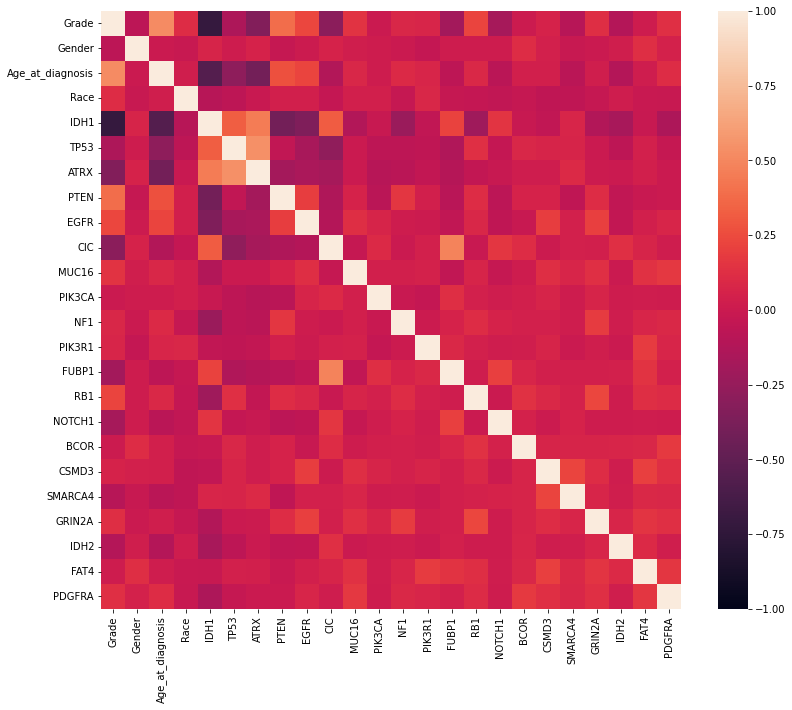

In [13]:
plt.figure(figsize=(13,11)) # задание размера выводимой фигуры
sns.heatmap(corrs, vmin=-1, vmax=1) # создание heatmap
plt.show() # вывод графика

In [14]:
# найдём максимальные корреляции (и обратные)
corrs_ = [] 
for i in range(data_train.shape[1]):
    for j in range(i+1, data_train.shape[1]): # идём по верхнетреугольной матрице
        corrs_.append([corrs[data_train.columns[i]][data_train.columns[j]], data_train.columns[i], data_train.columns[j]]) # заполняем таблицу корреляций подмассивами вида [значение, признак 1, признак 2]
corrs_ = sorted(corrs_) # сортируем по повышению значения

# выводим топ-20 коорелированных параметров
i_up = 0 # для динамической индексации с обоих концов массива
i_bottom = len(corrs_)-1
for i in range(20):
    if abs(corrs_[i_up][0]) > abs(corrs_[i_bottom][0]): # сравниваем корреляцию по модулю
        print(corrs_[i_up])
        i_up += 1
    else:
        print(corrs_[i_bottom])
        i_bottom -= 1

[-0.7174747581507976, 'Grade', 'IDH1']
[-0.5555315630523665, 'Age_at_diagnosis', 'IDH1']
[0.5435959085059712, 'TP53', 'ATRX']
[0.5229569420764796, 'Grade', 'Age_at_diagnosis']
[0.47665075615332053, 'CIC', 'FUBP1']
[0.44862454627015647, 'IDH1', 'ATRX']
[-0.4138295400474748, 'Age_at_diagnosis', 'ATRX']
[-0.4080160898198677, 'IDH1', 'PTEN']
[0.38555722122717967, 'Grade', 'PTEN']
[-0.35923270495350856, 'IDH1', 'EGFR']
[-0.338552452111398, 'Grade', 'ATRX']
[0.3254325140519197, 'IDH1', 'TP53']
[0.31656397429777366, 'IDH1', 'CIC']
[-0.3039516260660918, 'Grade', 'CIC']
[-0.2880757859788816, 'Age_at_diagnosis', 'TP53']
[-0.2749209389208053, 'TP53', 'CIC']
[0.2663517446791989, 'Age_at_diagnosis', 'PTEN']
[0.23071818366672, 'Grade', 'EGFR']
[0.22857367793245106, 'RB1', 'GRIN2A']
[-0.2283869238980205, 'IDH1', 'NF1']


#### * Реально значащая корреляция (хоть и обратная) наблюдается только у гена "IDH1" и болезни (Grade).

#### * Корреляция Пирсона ниже 0.5 (по модулю) считается средней и, в данном случае, рассматривается как "незначительная" или не оказывающая большого влияния.

Кроме того, можно заметить, что болезнь ещё средне зависима от возраста. Поэтому предполагается, что весовые коэффициенты у указанных признаков (возраст и "IDH1") будут самым значительными.

Среди же самих рассматриваемых признаков максимальная корреляция не превысила 0.6 (по модулю), поэтому никакие признаки отброшены не будут.

        Значения признаков:
* Gender — пол, может принимать значение 0 и 1, если пациент — мужчина или женщина, соответственно.
* Age_at_diagnosis — возрастр пациента, непрерывная величина, из-за сильного различия в области значений параметров была промасштабирована в область от 0 до 1. 
* Race - раса пациента, принимает значение от 0 до 3 в зависимости, собственно, от расы.
* 20 генов принимают значение 0, если они не мутировали, и 1 — если иначе.

### Разбиение датасета на выборку и таргет

In [15]:
features, targets = torch.tensor(data_train.iloc[:,1:].values), torch.tensor(data_train.iloc[:,:1].values).to(torch.float64) # приводим данные к тензорному виду
X_validation = torch.tensor(data_validation.values)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=test_size, random_state=random_state) # делаем train/test split

In [17]:
X_train

tensor([[0.0000, 0.9202, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6466, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2943, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.8424, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5367, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5351, 2.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [18]:
Y_train

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
      

## 2) Использование моделей

### a) K-Nearest Neighbors (KNN)

        KNN — простейший алгоритм классификации по количеству ближайших соседей.

In [19]:
# параметры для KNN
KNN_PARAMS = {'n_neighbors': list(range(2,20)), # число соседей
              'weights': ['uniform', 'distance']} # функция подсчёта веса (для близости между соседями)

In [20]:
model_knn_gs = GridSearchCV(KNeighborsClassifier(), KNN_PARAMS, cv=3) # обучаем модель с поиском наилучшей комбинации параметров
model_knn_gs.fit(X_train, Y_train.ravel()) # ravel преобразует эту форму массива в (n, ) (т.е. засунет всё в одномерный массив)
preds_knn = model_knn_gs.best_estimator_.predict(X_test) # делаем предсказание

        Проверяем работу модели (KNN), используя F1 score.

In [21]:
f1_score(Y_test, preds_knn) # считаем f1 score

0.806451612903226

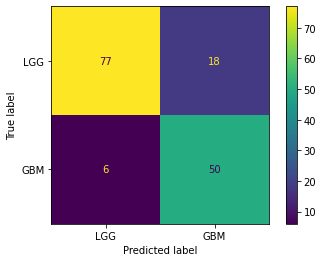

In [22]:
# вывод Confusion Matrix, отражающей качество предсказаний
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, preds_knn), display_labels = ["LGG", "GBM"]).plot()
plt.grid(False) # убирание сетки
plt.show() # вывод графика

        KNN модель довольно неплохо справилась с задачей. 
    - Ошибка при предсказании LGG составила 18 пациентов из 95, что примерно равно 0.189.
    - Ошибка для GBM - 6 из 56 пациентов, что ~ 0.107.
Таким образом простейшая KNN задала хорошую начальную планку для проверки качества последующих моделей.

### b) Логистическая регрессия

        Логистическая регрессия — хорошо интерпретируемая модель, так как веса в ней напрямую соответствуют признакам и отражают, на сколько изменится результат при изменении значения соответствующего признака. (сигмойда просто переводит получившееся число от перемножения весов на значение признака в область от 0 до 1).

In [27]:
losses = {"LogisticRegression": {"train":  [], "test": []}, "EnsembleModel": {"train":  [], "test": []}}

In [28]:
# определение модели
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size): # конструктор модели (input_size - число признаков, output_size - число таргетов для предсказания)
        super(LogisticRegression, self).__init__() # инициализация 
        self.linear = nn.Linear(in_features=input_size, out_features=output_size) # имеет линейный слой
        self.sigmoid = nn.Sigmoid() # сигмойда для приведения числа, полученного после линейного слоя в область от 0 до 1 (вероятность)

        self.linear.weight.data = torch.zeros((output_size, input_size), dtype=self.linear.weight.dtype) # зануление весов (для чистоты эксперимента)
        self.linear.bias.data = torch.zeros(output_size, dtype=self.linear.bias.dtype) # зануление bias (для чистоты эксперимента)

    def forward(self, X):
        pred = self.linear(X) # применяем линейный слой
        pred = self.sigmoid(pred) # вызываем сигмойду
        return pred # возвращаем предсказание

In [29]:
criterion = nn.BCELoss() # определяем функцию потерь — бинарную кросс-энтропию (хорошо для задачи бинарной классификации, где таргет может принимать лишь два значения - 0 и 1)
# При бинарной классификации каждая предсказанная вероятность сравнивается с фактическим значением класса (0 или 1), 
# и вычисляется оценка, которая штрафует вероятность на основе расстояния от ожидаемого значения.

# BCELoss выше, чем MSEloss примерно раза в 4 (на выбранном датасете), поэтому значение в 0.4 для BCE — это хорошо

In [30]:
model_log = LogisticRegression(X_train.shape[1], Y_train.shape[1]).to(torch.float64) # создаём объект модели

optimizer_1 = optim.Adam(model_log.parameters(), lr=learning_rate) # определяем оптимайзер — Adam и передаём в него веса модели с lr

for epoch in range(num_epochs): # проводим обучение и тестирование num_epochs раз
    Y_pred = model_log(X_train) # делаем предсказание
    loss = criterion(Y_pred, Y_train) # считаем ошибку по BCE loss

    losses["LogisticRegression"]["train"].append(loss.data) # запоминаем значение BCEloss

    optimizer_1.zero_grad() # обнуляем градиенты во всех обучаемых torch.Tensor (ставит w.grad = 0 в torch.Tensor с requires_grad=True) (вызывается перед loss.backward(), чтобы не аккумулировать градиенты за несколько итераций обучения)
    loss.backward() # считаем dloss/dw для каждого веса модели w, у которого requires_grad=True (сохраняется в w.grad следующим образом w.grad += dloss/dw)
    optimizer_1.step() # обновляет веса модели (тензоры, у которых стоит флаг requires_grad=True, используя значение из w.grad следующим образом w += -lr * w.grad)

    with torch.no_grad(): # запускаем валидацию (каждую эпоху)
        Y_pred = model_log(X_test) # вызываем forward с передачей X_test
        losses["LogisticRegression"]["test"].append(criterion(Y_pred, Y_test).data) # запоминаем значение BCEloss

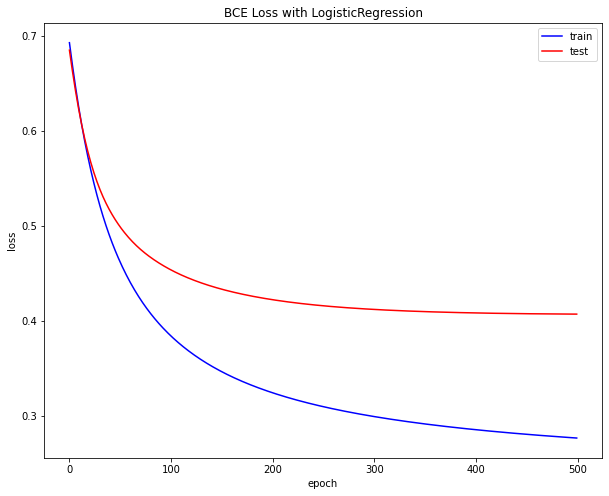

In [31]:
plt.figure(figsize=(10,8)) # задание размера графика
plt.plot(losses["LogisticRegression"]["train"], "b", label='train') # построение BCE loss на обучении
plt.plot(losses["LogisticRegression"]["test"], "r", label='test') # построение BCE loss на тестировании

plt.title('BCE Loss with LogisticRegression') # название графика
plt.xlabel('epoch') # подпись по оси x
plt.ylabel('loss') # подпись по оси y
plt.legend() # вывод названий графиков
plt.show() # вывод графика

        Проверяем работу модели (логистической регрессии), используя F1 score.

In [32]:
preds_log = model_log(X_test).detach() # делаем предсказание
preds_log = (preds_log>0.5).float() # конвертируем верояности в классы (типа float)
f1_score(Y_test, preds_log) # считаем f1 score

0.8166666666666667

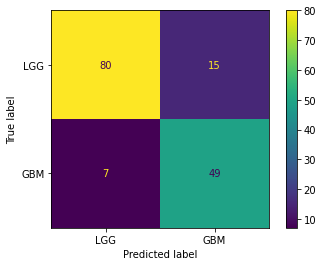

In [33]:
# вывод Confusion Matrix, отражающей качество предсказаний
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, preds_log), display_labels = ["LGG", "GBM"]).plot()
plt.grid(False) # убирание сетки
plt.show() # вывод графика

        Логистическая регрессия обогнала KNN по качеству предсказаний, увеличив F1 score почти на 1 процент (улучшив его для LGG, но ухудшив для GBM)!
    - Ошибка при предсказании LGG составила всего 15 пациентов из 95 (на 3 меньше, чем в KNN), что примерно равно 0.157 вероятности ошибки.   
    - Ошибка для GBM же немного ухудшилась - на один неправильно предсказанный диагноз по сравнению с KNN, 7 из 56 пациентов, что ~ 0.125.

In [50]:
model_log.linear.weight # вывод весов модели

Parameter containing:
tensor([[-0.1781,  2.3526,  0.4150, -2.4514,  0.4755, -1.2647,  0.9863, -0.2587,
         -1.7530,  0.6648, -0.2492, -1.0462,  0.4117, -1.1890,  1.8621, -2.3561,
         -0.4708,  0.9686, -1.3869,  1.9315, -1.8167,  0.5819,  2.2856]],
       dtype=torch.float64, requires_grad=True)

### c) Custom ensemble 

        Кастомная ансамблевая модель для эксперимента с обучаемыми/не обучаемыми параметрами.

In [34]:
class CustomModel(nn.Module):
    def __init__(self, input_size, output_size): # конструктор модели (input_size - число признаков, output_size - число таргетов для предсказания)
        super(CustomModel, self).__init__() # инициализация 
        self.linear1 = nn.Linear(in_features=input_size, out_features=input_size//4) # линейный слой
        self.dropout = nn.Dropout(p=0.2) # случайное зануление весов с вероятностью p=0.2
        self.linear2 = nn.Linear(in_features=input_size//4, out_features=output_size) # линейный слой
        self.sigmoid = nn.Sigmoid() # сигмойда для приведения числа, полученного после линейного слоя в область от 0 до 1 (вероятность)

    def forward(self, X):
        pred = self.linear1(X) # применяем линейный слой
        pred = self.dropout(pred) # случайно обнуляем веса для диверсификации
        pred = self.linear2(pred) # применяем линейный слой
        pred = self.sigmoid(pred) # вызываем сигмойду
        return pred # возвращение предсказания

In [35]:
class EnsembleModel(nn.Module):
    def __init__(self, base_model, n_estimators, input_size, output_size): # конструктор модели (base_model - какие модели будут в ансамбле, input_size - число признаков, output_size - число таргетов для предсказания)
        super(EnsembleModel, self).__init__() # инициализация 
        self.n_estimators = n_estimators # размер ансамбля
        self.ensemble = []
        for est in range(self.n_estimators): # добавляем модели в ансамбль
            self.ensemble.append(base_model(input_size, output_size).to(torch.float64))
        
    def forward(self, X):
        preds = torch.zeros((X.shape[0], 1)) # заготовка для предсказаний от моделей
        for est in range(self.n_estimators): # суммируем предсказания всех моделей
            preds += self.ensemble[est](X)
        preds = preds / self.n_estimators # берём среднее
        return preds.to(self.ensemble[-1].linear2.weight.dtype) # возвращаем предсказания (с кастом к типу выходного линейного слоя ~ типу модели)

In [36]:
model_ens = EnsembleModel(base_model=CustomModel, n_estimators=n_estimators, input_size=X_train.shape[1], output_size=Y_train.shape[1]) # создаём ансамбль моделей

# создаём список параметров для обучения
params = list()
for i in range(10):
    params += list(model_ens.ensemble[i].parameters())
optimizer_ens = optim.Adam(params, lr=learning_rate) # определяем оптимайзер — Adam и передаём в него веса модели с lr

for epoch in range(20): # немного обучим модель
    Y_pred = model_ens(X_train)

    loss = criterion(Y_pred, Y_train) # считаем ошибку по BCE loss
    losses["EnsembleModel"]["train"].append(loss.data) # запоминаем значение BCEloss
    
    optimizer_ens.zero_grad() # обнуляем градиенты во всех обучаемых torch.Tensor (ставит w.grad = 0 в torch.Tensor с requires_grad=True) (вызывается перед loss.backward(), чтобы не аккумулировать градиенты за несколько итераций обучения)
    loss.backward() # считаем dloss/dw для каждого веса модели w, у которого requires_grad=True (сохраняется в w.grad следующим образом w.grad += dloss/dw)
    optimizer_ens.step() # обновляет веса модели (тензоры, у которых стоит флаг requires_grad=True, используя значение из w.grad следующим образом w += -lr * w.grad)
    
    with torch.no_grad(): # запускаем валидацию (каждую эпоху)
        Y_pred = model_ens(X_test) # вызываем forward с передачей X_test
        losses["EnsembleModel"]["test"].append(criterion(Y_pred, Y_test).data) # запоминаем значение BCEloss

# отключаем обучение у весов
for e_num in range(n_estimators//2): # рассматриваем по "половине" моделей в ансамбле
    model_ens.ensemble[e_num].linear1.weight.requires_grad = False # у первой половины моделей в ансамбле отключаем обновление весов первого слоя
    model_ens.ensemble[e_num].linear1.bias.requires_grad = False # и для bias (смещения)
    model_ens.ensemble[e_num+5].linear2.weight.requires_grad = False # у второй половины моделей в ансамбле отключаем обновление весов второго слоя
    model_ens.ensemble[e_num+5].linear2.bias.requires_grad = False # и для bias (смещения)

for epoch in range(num_epochs-20): # проводим обучение и валидацию num_epochs раз (-20, так как 20 эпох мы уже обучали)
    Y_pred = model_ens(X_train) # делаем предсказание

    loss = criterion(Y_pred, Y_train) # считаем ошибку по BCE loss
    losses["EnsembleModel"]["train"].append(loss.data) # запоминаем значение BCEloss

    optimizer_ens.zero_grad() # обнуляем градиенты во всех обучаемых torch.Tensor (ставит w.grad = 0 в torch.Tensor с requires_grad=True) (вызывается перед loss.backward(), чтобы не аккумулировать градиенты за несколько итераций обучения)
    loss.backward() # считаем dloss/dw для каждого веса модели w, у которого requires_grad=True (сохраняется в w.grad следующим образом w.grad += dloss/dw)
    optimizer_ens.step() # обновляет веса модели (тензоры, у которых стоит флаг requires_grad=True, используя значение из w.grad следующим образом w += -lr * w.grad)

    with torch.no_grad(): # запускаем тестирование (каждую эпоху)
        Y_pred = model_ens(X_test) # вызываем forward с передачей X_test
        losses["EnsembleModel"]["test"].append(criterion(Y_pred, Y_test).data) # запоминаем значение BCEloss

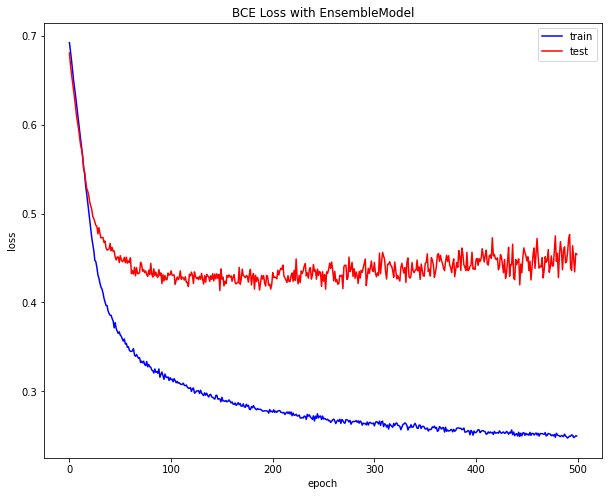

In [37]:
plt.figure(figsize=(10,8)) # задание размера графика
plt.plot(losses["EnsembleModel"]["train"], "b", label='train') # построение BCE loss на обучении
plt.plot(losses["EnsembleModel"]["test"], "r", label='test') # построение BCE loss на тестирование
plt.title('BCE Loss with EnsembleModel') # название графика
plt.xlabel('epoch') # подпись по оси x
plt.ylabel('loss') # подпись по оси y
plt.legend() # вывод названий графиков
plt.show() # вывод графика

        Проверяем работу ансамбля моделей, используя F1 score.

In [38]:
preds_ens = model_ens(X_test) # делаем предсказание
preds_ens = (preds_ens>0.5).float() # конвертируем верояности в классы (типа float)
f1_score(Y_test, preds_ens) # считаем f1 score

0.8130081300813009

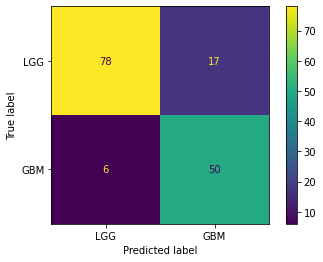

In [39]:
# вывод Confusion Matrix, отражающей качество предсказаний
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, preds_ens), display_labels = ["LGG", "GBM"]).plot()
plt.grid(False) # убирание сетки
plt.show() # вывод графика

        Ансамблевая модель получилась довольно случайной, из-за остановки обучения весов и наличия dropout, однако это не помешало ей слегка обогнать KNN и почти достать логистическую регрессию по F1 score.
    - Ошибка при предсказании LGG составила всего 17 пациентов из 95 (на 1 меньше, чем в KNN и на 2 больше, чем в логистической регрессии), что примерно равно 0.178 вероятности ошибки при предсказании.
    - Ошибка для GBM — 6 из 56 пациентов (что аналогично результату KNN и на 1 меньше, чем в логистической регрессии) ~ 0.107.

### d) Random Forest Classifier

        Случайный лес — ансамблевая модель, в которой присутствует множество decision tree классификаторов, обученных на разных частях датасета. Для финального предсказания использует среднее от всех деревьев.

In [ ]:
FOREST_PARAMS = { # параметры для Random Forest
    "n_estimators": [5, 10, 25], # число деревьев в лесу
    "criterion": ["gini", "entropy"], # функция для оценивания качества сплита в узле
    "max_depth": [None, 5, 25, 50], # максимальная глубина деревьев (None - глубина не ограничена)
    "min_samples_split": [2, 5, 10], # минимальное число экземпляров, необходимое для сплита в узле
    "max_features": [None, "sqrt"] # количество признаков, которые следует учитывать при поиске лучшего разделения (None - все признаки)
} 

In [ ]:
model_forest_gs = GridSearchCV(RandomForestClassifier(), FOREST_PARAMS, cv=3) # обучаем модель с поиском наилучшей комбинации параметров
model_forest_gs.fit(X_train, Y_train.ravel()) # ravel преобразует эту форму массива в (n, ) (т.е. засунет всё в одномерный массив)
preds_forest = model_forest_gs.best_estimator_.predict(X_test)

        Проверяем работу модели (случайного леса), используя F1 score.

In [ ]:
f1_score(Y_test, preds_forest) # считаем f1 score

0.8205128205128205

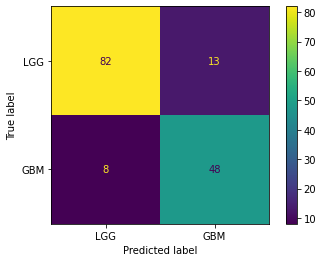

In [ ]:
# вывод Confusion Matrix, отражающей качество предсказаний
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, preds_forest), display_labels = ["LGG", "GBM"]).plot()
plt.grid(False) # убирание сетки
plt.show() # вывод графика

        Случайный лес показал наилучшие результаты среди всех рассматриваемых моделей по F1 score. 
    - Ошибка при предсказании LGG составила рекордные 13 пациентов из 95 (ещё на 2 меньше, чем в логистической регресии), что примерно равно 0.136 вероятности ошибки при предсказании.
    - Ошибка для GBM же у этой модели — худшая, целых 8 пациентов из 56 (на 1 больше, чем у логистической регрессии и на два больше, чем у KNN и ансамбля), что ~ 0.142.
Обобщая, случайный лес улучшил качество предсказаний, подняв при этом F1 score до 0.820 и почти сравняв ошибки для обоих классов.

## 3) Выводы

        В работе были рассмотрены 4 модели (KNN, Logistic Regression, Custom Ensemble, Random Forest) и проведён анализ их обучения с предсказаниями на датасете данных об опухолях головного мозга.

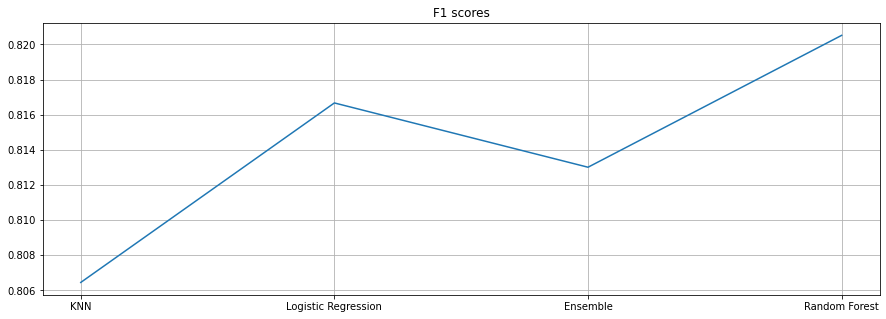

In [45]:
plt.figure(figsize=(15, 5)) # размер графика
f1_scores = [f1_score(Y_test, preds_knn), f1_score(Y_test, preds_log), f1_score(Y_test, preds_ens), f1_score(Y_test, preds_forest)] # подсчёт f1 score
plt.grid(True) # включаем сетку для облегчения сравнения
plt.plot(["KNN", "Logistic Regression", "Ensemble", "Random Forest"], f1_scores) # строим график значений F1 score
plt.title("F1 scores") # заголовок графика
plt.show() # выводим график

        Самой лучшей моделью среди рассмотренных оказался — случайный лес.

#### Предсказание на валидационной выборке

In [46]:
# предсказание
preds_validation = model_forest_gs.best_estimator_.predict(X_validation) # делаем предсказание
preds_validation = (preds_validation>0.5).astype(float) # конвертируем верояности в классы (типа float)

In [47]:
# запись в файл
with open("./submissions/submission.csv", "w") as f: # открытие файла на запись
    f.write("Id,Grade\n") # первая строка файла заданного формата
    for i in range(X_validation.shape[0]): # записываем предсказания для каждого инпута
        f.write(f"{i},{int(preds_validation[i])}\n") # запись строк в формате "id пациента,предсказание"